<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, track our experiment runs and inspect the logs using MLflow, and apply [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model architectures, followed by explaining the model with SHAP.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- track tensorflow experiments with MLflow, access information of runs programmatically and with its tracking ui
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [ ]:
# # Connect colab to your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install -q seaborn # pairplot
# !pip install -q tpot  # automl
# 
# !pip install -q mlflow # tracking
# !pip install -q pyngrok # workaround to run mlflow ui in colab
# !pip install -q shap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


# Task 1 - Data: Auto MPG dataset

0. Start MLflow's automatic logging using library-specific autolog calls for tensorflow: logging metrics, parameters, and models without the need for explicit log statements. 
    
    We will get into more details using **MLflow** after completing our experiment.

In [3]:
import mlflow
mlflow.tensorflow.autolog() # MLflow Autologging

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [5]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [6]:
# check how much data is missing:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# drop missing rows missing data (6 rows)
dataset = dataset.dropna()

In [8]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [9]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset  = dataset.drop(train_dataset.index)

5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

In [12]:
# count unique values in each column of train:
train_dataset.nunique()

MPG             108
Cylinders         5
Displacement     76
Horsepower       85
Weight          288
Acceleration     89
Model Year       13
Europe            2
Japan             2
USA               2
dtype: int64

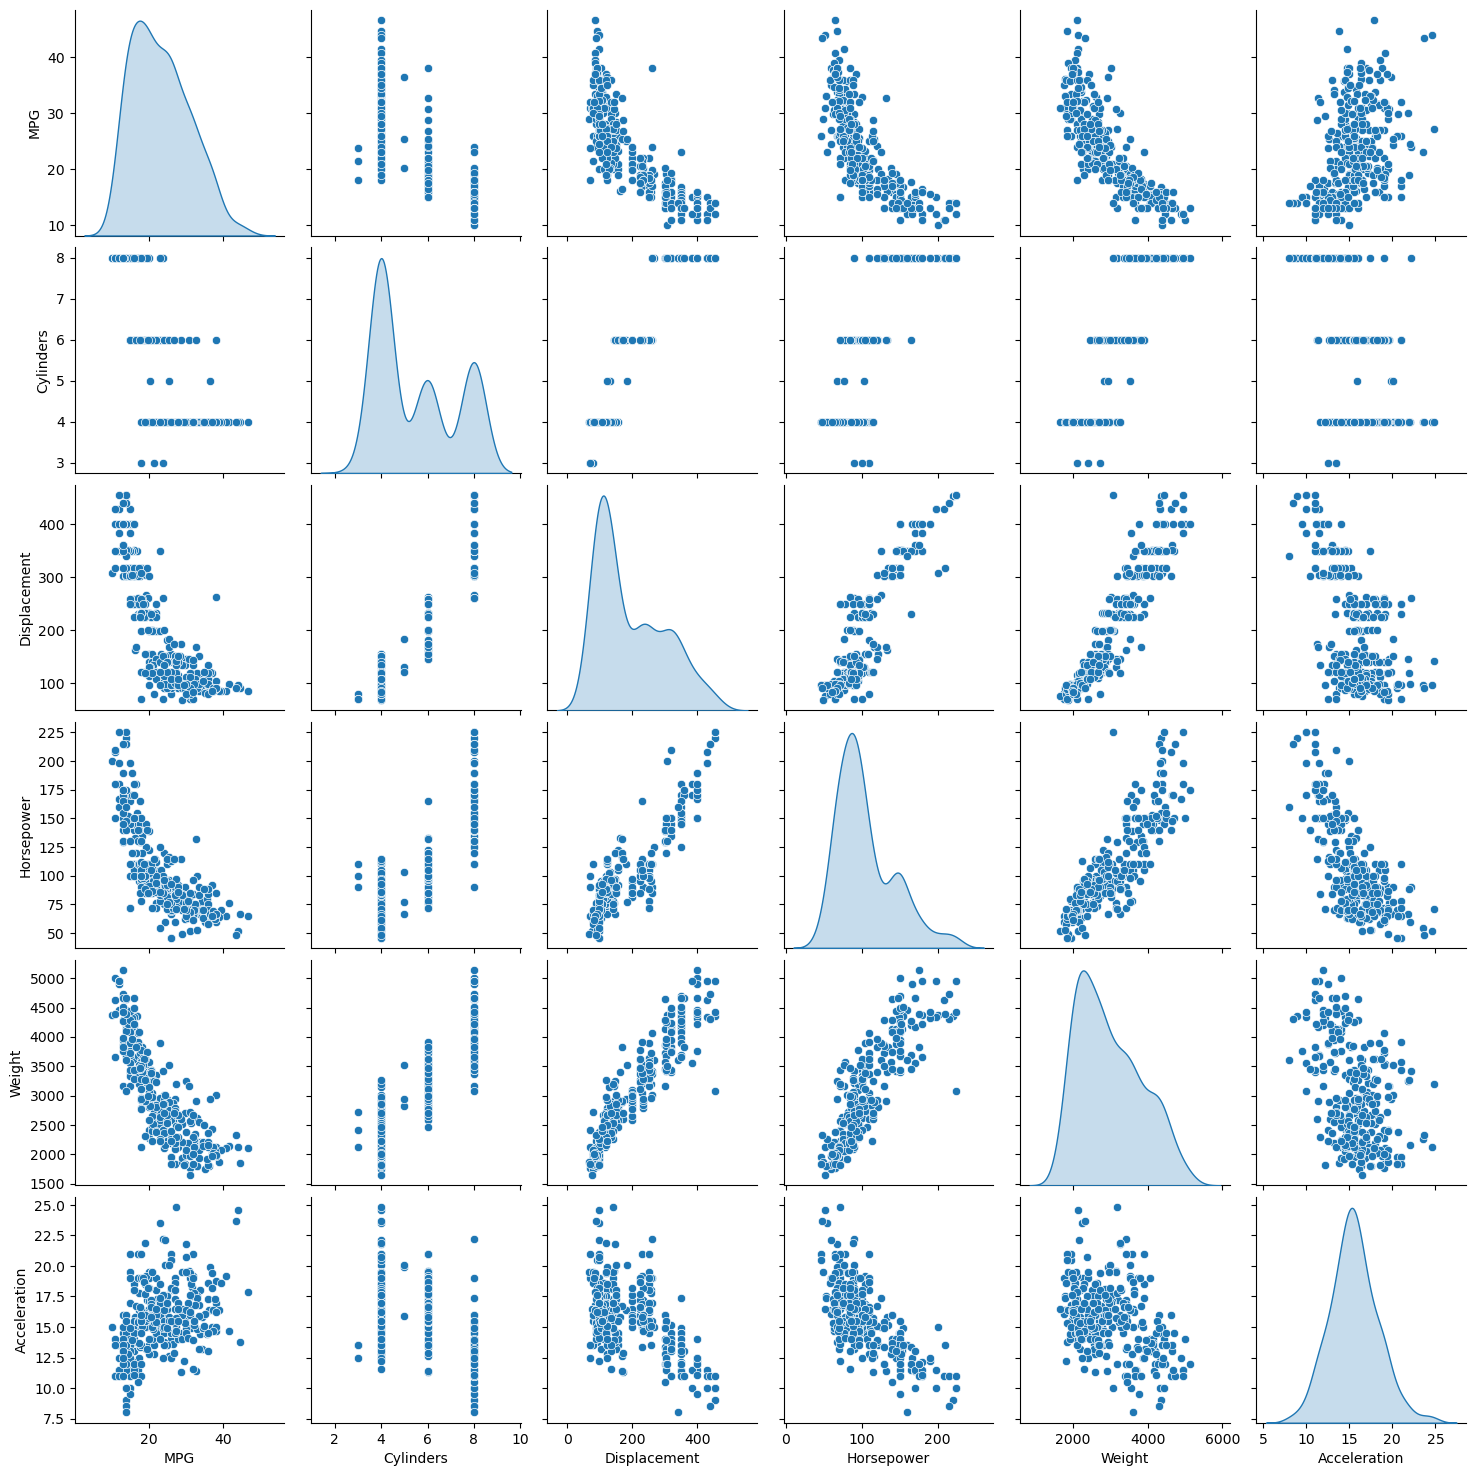

In [13]:
# add horsepower, acceleration to pairplot:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement',
                            'Horsepower', 'Weight', 'Acceleration']],
             diag_kind='kde')

plt.show()

### _...Above fig. shows a lot of correlations here..._

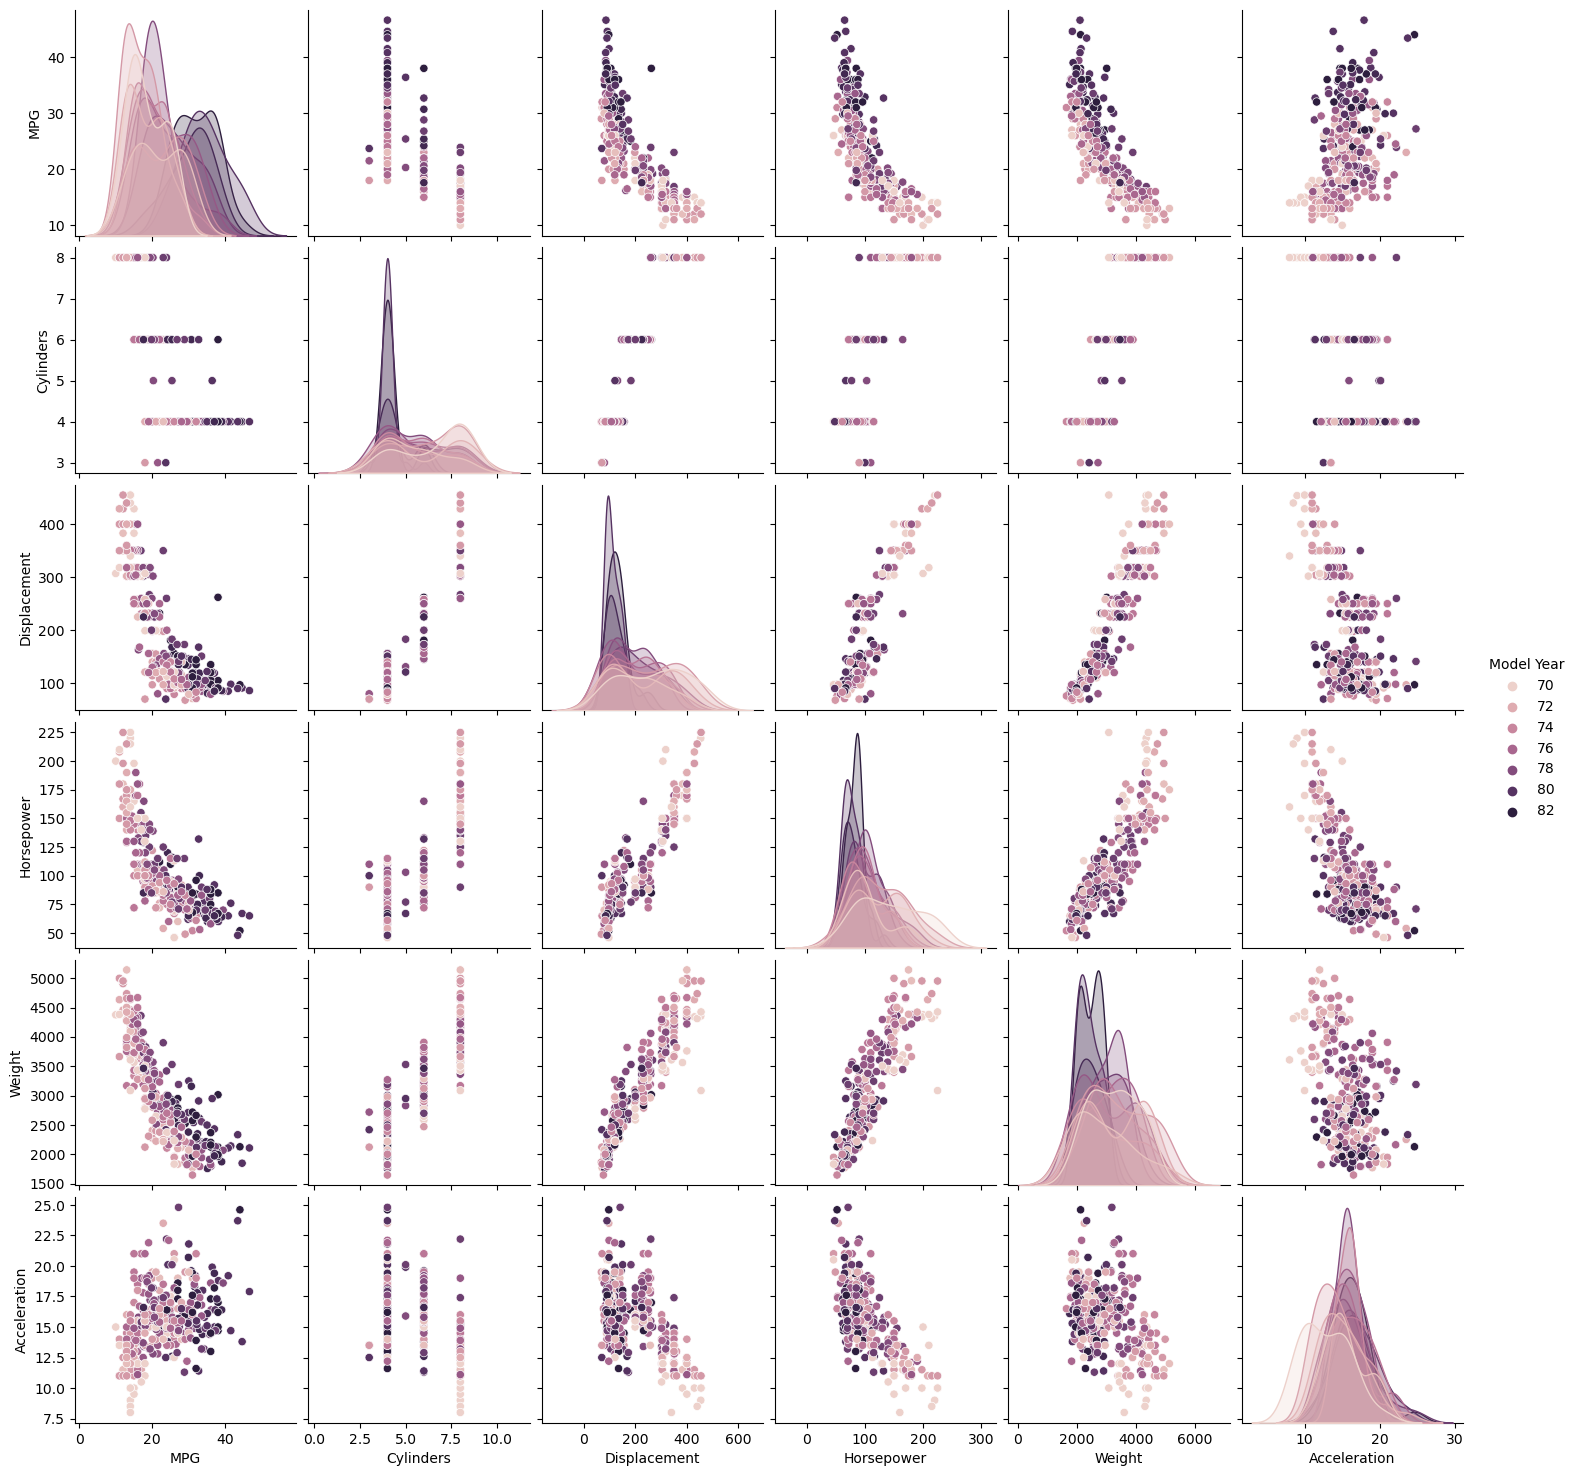

In [14]:
# look at pairplot adding hue semantic mapping for # Model Year
sns.pairplot(train_dataset, vars=train_dataset.iloc[:,:6], hue='Model Year')

plt.show()

### _...The above fig. suggests that newer cars are generally more fuel efficient across any given feature..._

Let's also check the overall statistics. Note how each feature covers a very different range:

In [15]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [16]:
test_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,78.0,23.991026,8.133563,9.0,18.00,24.00,29.875,44.3
Cylinders,78.0,5.448718,1.740633,3.0,4.00,4.00,8.000,8.0
Displacement,78.0,190.762821,106.494733,70.0,98.00,138.00,292.000,400.0
Horsepower,78.0,102.858974,40.255265,48.0,74.25,90.00,121.750,230.0
Weight,78.0,2926.589744,874.900416,1613.0,2159.50,2692.50,3706.500,4746.0
Acceleration,78.0,15.469231,2.649298,8.5,13.70,15.25,17.000,22.2
Model Year,78.0,76.307692,3.721847,70.0,73.00,76.00,79.750,82.0
Europe,78.0,0.153846,0.363137,0.0,0.00,0.00,0.000,1.0
Japan,78.0,0.217949,0.415525,0.0,0.00,0.00,0.000,1.0
USA,78.0,0.628205,0.486412,0.0,0.00,1.00,1.000,1.0


6. Split features from labels. 
  This means, separate the target value(also called"label") from the features. 
  Label is the value that you will train the model to predict.

In [17]:
train_features = train_dataset.loc[:, train_dataset.columns != 'MPG']
test_features  =  test_dataset.loc[:,  test_dataset.columns != 'MPG']

train_labels = train_dataset['MPG']
test_labels  =  test_dataset['MPG']

# Task 2 - Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

NB: This layer shifts and scales inputs into a distribution with μ = 0 and σ = 1; it ***requires*** μ and σ^2 (supplied, learned, or via `adapt()`.

In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)
# NB: axis defaults to -1, where the last axis of the input
# is assumed to be a feature dim (which is the case here)
# and is normalized per index

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [19]:
# calculate a mean and variance for each index on the last axis,
# first converting train_features df to np array:
normalizer.adapt(np.array(train_features))

2022-10-04 00:45:52.265982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 00:45:52.267195: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We can see the feature mean and variance are stored in the layer:

In [20]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]

feature variance: [     2.88   10850.413   1446.699 709896.9        7.755     13.467
      0.147      0.158      0.235]


When the layer is called, it returns the input data, with each feature independently normalized:

In [21]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Task 3 - Linear Regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this earlier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce one output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [22]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)    # NB: no activation function here!
])

In [23]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


### _Parameters for above linear model:_
* 19 _untrainable parameters:_ normalization of 9 features requires  
2 parameters per feature (μ and σ) ＝ 9 × 2 or 18 parameters  
(not sure where the 19th comes from!)
* 10 _trainable parameters:_ For the single densely connected layer of one node &   
linear transformation &#x176; = W<sup>T</sup>X + b, there are
9 weight parameters w<sub>i</sub> (one for each feature) and  
the bias term, b = 10 parameters total ✔

2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [24]:
linear_model.predict(train_features[:10])

array([[ 1.231],
       [ 1.028],
       [-0.151],
       [ 0.421],
       [-0.914],
       [ 0.606],
       [-0.654],
       [-0.372],
       [ 0.999],
       [ 0.102]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [25]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.003],
       [-0.316],
       [ 0.502],
       [-0.584],
       [ 0.714],
       [-0.301],
       [-0.41 ],
       [-0.618],
       [ 0.415]], dtype=float32)>

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [26]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
    )

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [27]:
%%time
history = linear_model.fit(
    x=train_features,    # why shouldn't this be x=np.array(train_features)??
    y=train_labels,      # why shouldn't this be y=np.array(train_lebels)  ??
                         # since tf.keras.Model.fit documentation states that
                         # x & y must be np array or tf tensor
    epochs=100,
    verbose=0,
    validation_split=0.2
    )

2022/10/04 00:45:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aadee128b485432bbb9d03314bd0e6d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


INFO:tensorflow:Assets written to: /tmp/tmpy5fpp9b2/model/data/model/assets


2022-10-04 00:45:55.386690: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022/10/04 00:45:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/fslee/miniconda3/envs/wk7_shap/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


CPU times: user 2.41 s, sys: 295 ms, total: 2.71 s
Wall time: 5.1 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# let's see all epochs:
pd.set_option('display.max_rows',100)
display(hist)
pd.reset_option('display.max_rows')

,loss,val_loss,epoch
0,22.876907,23.061914,0
1,22.062536,22.363487,1
2,21.203926,21.635517,2
3,20.399204,20.908987,3
4,19.569847,20.185753,4
5,18.742655,19.484200,5
6,17.940958,18.771433,6
7,17.114223,18.064907,7
8,16.304426,17.354115,8
9,15.471279,16.652542,9


In [29]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

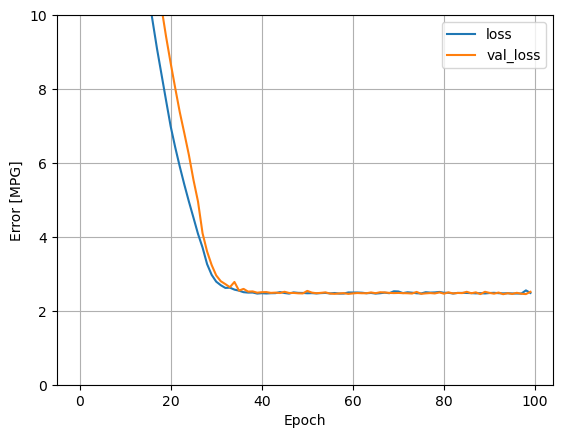

In [30]:
plot_loss(history)
plt.show()

### _...OK, this figure suggests that:_
* At least until the 'elbow', linear_model is slightly overfitting  
the training data (until epoch ≈ 30)
* After about epoch 30, further training doesn't → ↓ error (predicted MPG)

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [31]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    x=test_features,
    y=test_labels,
    verbose=0,
    )

In [32]:
test_results

{'linear_model': 2.5980122089385986}

### _...the `test_results` loss is comparable to that of training data..._

### _Let's look how well the `linear_model` did with its predictions on test:_

In [33]:
test_predictions = linear_model.predict(
                       x=test_features,
                       verbose=0,
                       )

In [34]:
# plot linear_model predictions v. labels:
def plot_linear_model(predictions, labels):
    plt.scatter(labels, predictions)
    lims = [0,50]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('Labels (actual mpg)')
    plt.ylabel('Predicted mpg')
    plt.title('MPG Predictions v. Labels (Test set data)')
    plt.grid(True)

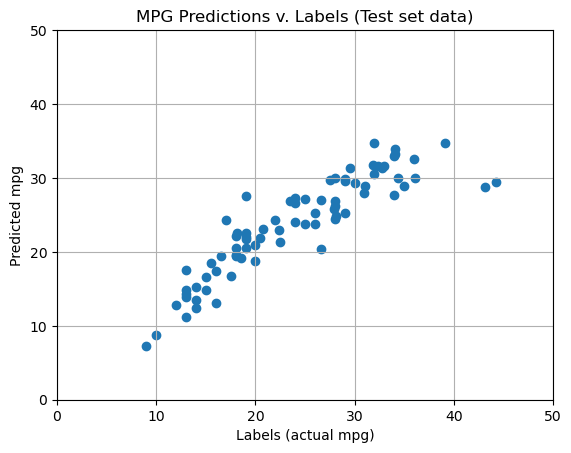

In [35]:
# generate scatter plot:
plot_linear_model(test_predictions.flatten(), test_labels)

plt.show()

### _...ok, the linear_model is not bad..._

# Task 4 - Regression with a Deep Neural Network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [36]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())    # default α = 0.001
    return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [37]:
dnn_model = build_and_compile_model(normalizer)

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [38]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


### _Check # parameters:_
* normalization parameters _(non-trainable):_ 9 input features = 19 (as before)
* The remaining model parameters are _trainable:_  
    * densely connected layer-1 w/ 64 nodes: 64 × (9 + 1) = 640  
    * densely connected layer-2 w/ 64 nodes: 64 × (64 + 1) = 4,160  
    * densely connected layer-3 w/  1 node :  1 × (64 + 1) = 65  
    for Σ = 4,865 _trainable parameters_ ✔

4. Train the model with Keras `Model.fit`:

In [39]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2022/10/04 00:47:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dd393fcf400d4b909f3b46a2213c6dc8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


INFO:tensorflow:Assets written to: /tmp/tmpyb_ur913/model/data/model/assets
CPU times: user 51.5 s, sys: 1min 49s, total: 2min 40s
Wall time: 9.62 s


5. Visualize the model's training progress using the stats stored in the history object. 

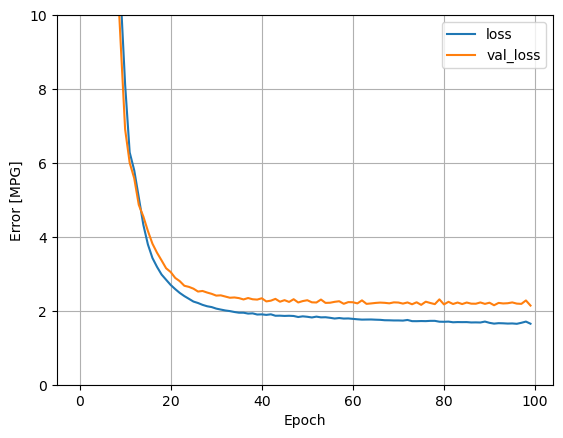

In [40]:
plot_loss(history)

plt.show()

Do you think the DNN model is overfitting? What gives away? 

    *YOUR ANSWER HERE*

### _Answer:_

These results are somewhat reminiscent of the previous `linear_model`, except  
the loss here is a bit lower (validation set loss ≈ 2.2 compared with ～2.5 for  
the `linear_model`). Similarly, it looks like the DNN model is overfitting:  
* From epoch 16 onward, validation loss > training loss.
* From epoch 30 onward, validation loss reaches a stable minimum, while    
training loss continues to decrease, progressively diverging from validation  
loss.
* The widening Δ (validation loss - training loss) beyond epoch 16 likely    
reflects the DNN overfitting the training data.

6. Let's save the results for later comparison.

In [41]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Task 5 - Make Predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [42]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.598012
dnn_model,1.724204


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

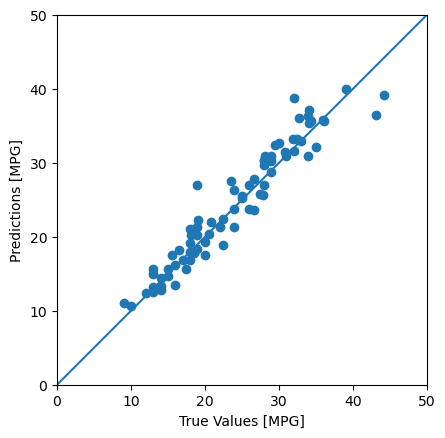

In [43]:
test_predictions = dnn_model.predict(
                       x=test_features,
                       verbose=0,
                       )

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

plt.show()

3. It appears that the model predicts reasonably well. Now, check the error distribution:

In [44]:
print(f'test_predictions has shape:\t{test_predictions.shape}\n'
      f'test_labels has shape:\t\t{test_labels.shape}')

test_predictions has shape:	(78, 1)
test_labels has shape:		(78,)


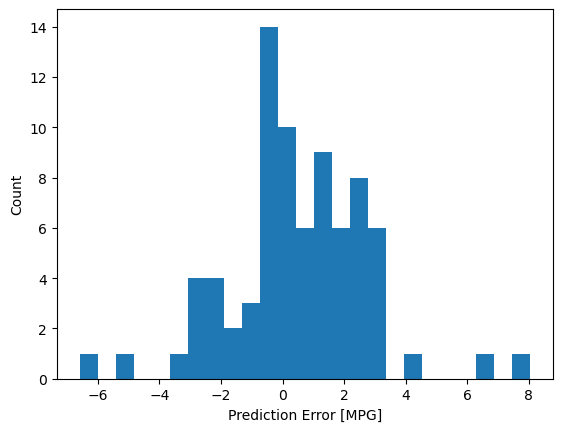

In [45]:
# plotting abs errors (since our model loss fxn = mean abs error):
error = test_predictions.flatten() - test_labels

plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

plt.show()

4. Save it for later use with `Model.save`:

In [46]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


5. Reload the model with `Model.load_model`; it gives identical output:

In [47]:
reloaded = tf.keras.models.load_model('dnn_model')
test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [48]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.598012
dnn_model,1.724204
reloaded,1.724204


# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Since there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [49]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to:

    a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot 
    
    b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [50]:
def plot_displacement(x, y):
    plt.scatter(train_features['Displacement'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Displacement')
    plt.ylabel('MPG')
    plt.legend()

3. Visualize predicted MPG using the linear model.

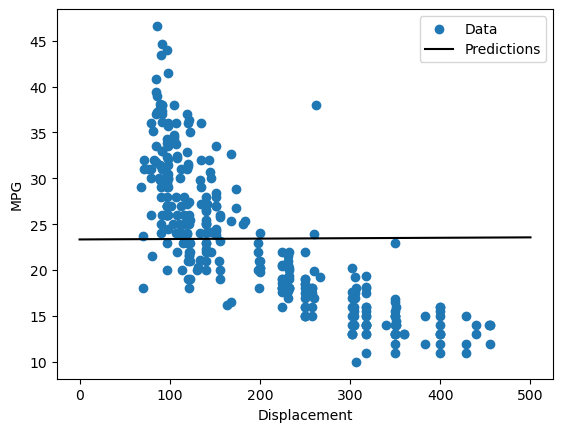

In [51]:
plot_displacement(fake.Displacement, linear_model(fake))

plt.show()

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

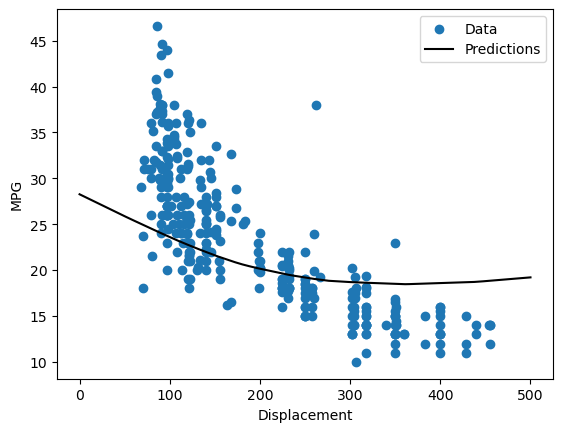

In [52]:
plot_displacement(fake.Displacement, dnn_model.predict(fake))

plt.show()

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
  
  Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks?

### _Answer:_

Unfortunately, overfitting is a common problem with DNNs, given their  
inherent complexity and seemingly unlimited capacity to learn a function  
in the hypothesis space that does a reasonably good job _(or too good a job  
in the case of overfitting!)_ of mapping the input training data to    
correct ground-truth labels.  

Approaches to mitigating DNN overfitting fall under two general categories:  
* __↑ training data__ (esp. that representing the fullest diversity of  
inputs likely to be encountered during inference)    

* __↓ model complexity:__ these methods include:  
    * __↓ no. trainable parameters__  
        * ↓ no. hidden layers ± no. nodes  
    * __regularization__  
        * _weight decay:_ penalize larger magnitude parameters  
        * _weight constraint:_ contrain magnitude of parameters
        * _dropout_ (during training)
        * penalize _larger magnitude activations_
        * _early stopping_ (by monitoring validation set performance)  
    

# Task 7 - MLflow Tracking

In this task, we briefly explore [MLflow Tracking](https://www.mlflow.org/docs/latest/tracking.html#tracking), one of four primary functions that MLflow offers for managing the end-to-end machine learning lifecycle. We will access the information runs programmatically in python and then set up the MLflow UI for easy interaction.

1. Experiments.

    MLflow Tracking is organized around the concept of `runs`, which are executions of some piece of modeling code; and runs are organized into experiments. 

    We set the auto logging in the beginning, we can verify that
    - there is one experiment
    - its name is `0`
    - all of its artifacts are stored at `file:///content/mlruns/0` in Google Drive.

In [53]:
from mlflow import MlflowClient
client = MlflowClient()
    # client.list_experiments()    # DEPRECATED!
    
experiments = client.search_experiments(order_by=['experiment_id DESC'])
print(experiments)

[<Experiment: artifact_location='file:///mnt/f/4b/code/FrederickMLE-9/assignments/week-7-intro-dl/nb/mlruns/0', creation_time=1664661132008, experiment_id='0', last_update_time=1664661132008, lifecycle_stage='active', name='Default', tags={}>]


In [54]:
print(type(experiments))

<class 'mlflow.store.entities.paged_list.PagedList'>


2. Runs. 

   List information for runs that are under experiment '0' using [`mlflow.list_run_infos()`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.list_run_infos).

In [55]:
    # mlflow.list_run_infos() DEPRECATED!
runs = client.search_runs(['0'], order_by=['metrics.loss ASC'])
print(runs)

[<Run: data=<RunData: metrics={'loss': 1.618151068687439, 'val_loss': 2.0426206588745117}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.2',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "b7374feb5b8a443d9c906641f83a03b9", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-10-03 22:03:50.733693", "flavors": '
                             '{"keras": {"keras_module": "tensorflow.keras", '
                          

3. Retrieve the currently active run, i.e., the DNN model. Hint: `mlflow.last_active_run()` 

In [56]:
autolog_run = mlflow.last_active_run()
print(autolog_run)

<Run: data=<RunData: metrics={'loss': 1.6507929563522339, 'val_loss': 2.1416361331939697}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.2',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "dd393fcf400d4b909f3b46a2213c6dc8", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-10-04 04:47:14.866320", "flavors": '
                             '{"keras": {"keras_module": "tensorflow.keras", '
                          

4. Use function `print_auto_logged_info` provided below to fetch the auto logged parameters and metrics for `autolog_run`. 

In [57]:
import json
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(json.dumps(r.data.params, indent=4)))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

In [58]:
print_auto_logged_info(autolog_run) 

run_id: dd393fcf400d4b909f3b46a2213c6dc8
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {
    "batch_size": "None",
    "class_weight": "None",
    "epochs": "100",
    "initial_epoch": "0",
    "max_queue_size": "10",
    "opt_amsgrad": "False",
    "opt_beta_1": "0.9",
    "opt_beta_2": "0.999",
    "opt_decay": "0.0",
    "opt_epsilon": "1e-07",
    "opt_learning_rate": "0.001",
    "opt_name": "Adam",
    "sample_weight": "None",
    "shuffle": "True",
    "steps_per_epoch": "None",
    "use_multiprocessing": "False",
    "validation_batch_size": "None",
    "validation_freq": "1",
    "validation_split": "0.2",
    "validation_steps": "None",
    "workers": "1"
}
metrics: {'loss': 1.6507929563522339, 'val_loss': 2.1416361331939697}
tags: {}


5. Optional. Retrieve the best run using [MlflowClient().search_runs()](https://www.mlflow.org/docs/latest/search-runs.html#python).

In [59]:
# here, we'll search all available runs in experiment_id='0' for the 
# lowest metric='loss':

runs = client.search_runs(['0'], order_by=['metrics.loss ASC'])

In [60]:
runs[0]

<Run: data=<RunData: metrics={'loss': 1.618151068687439, 'val_loss': 2.0426206588745117}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.2',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "b7374feb5b8a443d9c906641f83a03b9", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-10-03 22:03:50.733693", "flavors": '
                             '{"keras": {"keras_module": "tensorflow.keras", '
                           

6. To see what's logged in the file system `/content/mlruns/`, click tab `files` in the left sidepanel in Colab. For example, 
    ```
    mlruns
    └── 0
        ├── 3a5aebdd35ef46fb8dc35b40e542f0a4
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        ├── c627bc526c4a4c418a8285627e61a16d
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        └── meta.yaml

    11 directories, 3 files
    ```

    Inspect the model summary of the DNN model you ran previously; it is located at `artifacts/model_summary.txt` of the corresponding run. Use `cat $filepath`. 

### _Model summary of 'best' performing model run:_  
i.e., model run with the lowest `metric='loss'`:  

As shown in the cell above, the `run_id` for the lowest loss achieved  
in these experiments viz. `'loss': 1.618151068687439, 'val_loss': 2.0426206588745117`  
is `"run_id": "b7374feb5b8a443d9c906641f83a03b9"`  

_Getting model_summary for this run:_

In [61]:
%%bash
cat './mlruns/0/b7374feb5b8a443d9c906641f83a03b9/artifacts/model_summary.txt'

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________

7. Tracking UI. 

    MLflow provides an UI for us to visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools. 

    If your runs are logged to a local mlruns directory, run `mlflow ui` in the directory above it will load the corresponding runs. 
    
    Running localhost server in Colab, however, requires a bit of extra work:
    - set up a free account on [ngrok](https://dashboard.ngrok.com/get-started/setup)
    - retrieve the authtoken from https://dashboard.ngrok.com/auth and update the code cell below
    
   **NOTE**. NEVER share your secrets. Best to keep `NGROK_AUTH_TOKEN` as an environment variable and retrieve it via `os.environ.get("NGROK_AUTH_TOKEN")`.

In [62]:
# # run tracking UI in the background
# get_ipython().system_raw("mlflow ui --port 5000 &") 
# 
# # create remote tunnel using ngrok.com to allow local port access
# from pyngrok import ngrok
# # Terminate open tunnels if exist
# ngrok.kill()
# 
# # Setting the authtoken (see Note above)
# NGROK_AUTH_TOKEN = "2EpLAwBPBxY5nlcuUvddGKOumUD_7pfLCJRhe9ku896xysV46"  # YOUR CODE HERE
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)
# 
# # Open an HTTPs tunnel on port 5000 for http://localhost:5000
# ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
# print("MLflow Tracking UI:", ngrok_tunnel.public_url)

8. Interact with Tracking UI. 

    Open the link, output from the previous cell. get oriented, `Parameters`, `Metrics`, `Artifacts`, and so on.
    
    When you are done, make sure to terminate the open tunnel:

### _...Running this notebook locally, so:_

In [63]:
!mlflow ui

[2022-10-04 00:49:45 -0400] [27774] [INFO] Starting gunicorn 20.1.0
[2022-10-04 00:49:45 -0400] [27774] [INFO] Listening at: http://127.0.0.1:5000 (27774)
[2022-10-04 00:49:45 -0400] [27774] [INFO] Using worker: sync
[2022-10-04 00:49:45 -0400] [27777] [INFO] Booting worker with pid: 27777
^C
[2022-10-04 00:49:50 -0400] [27774] [INFO] Handling signal: int
[2022-10-04 00:49:51 -0400] [27777] [INFO] Worker exiting (pid: 27777)


### _...OK, this is pretty amazing!:_

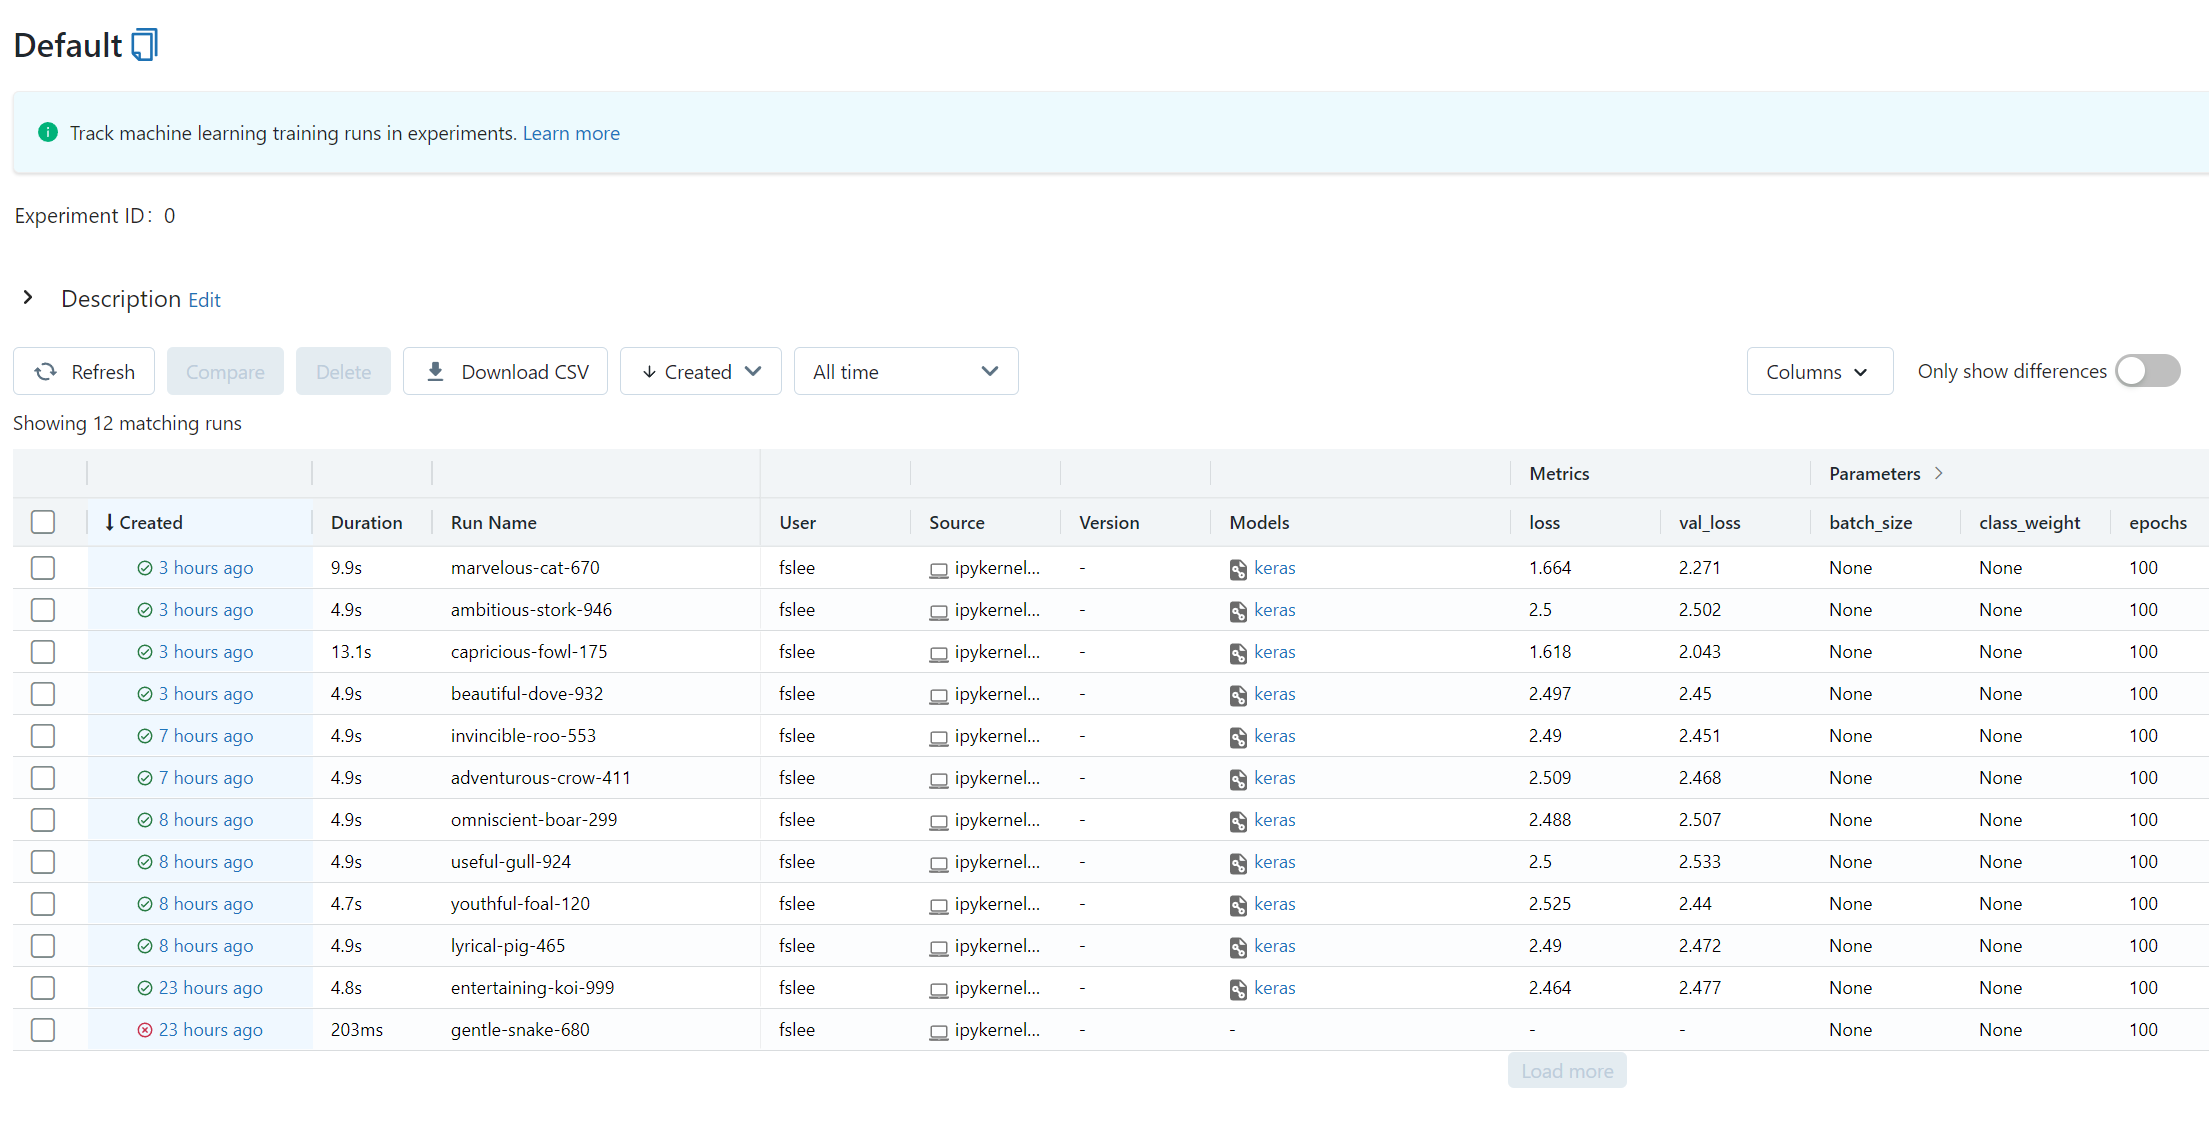

In [64]:
# ngrok.kill()

# Task 8 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

  The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

  `generations`: 10

  `population_size`: 40

  `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

  `verbosity`: 2 (so you can see each generation's performance)

  The final line with create a Python script tpot_products_pipeline.py with the code to create the optimal model found by TPOT.

In [65]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='neg_mean_absolute_error',
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpot score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

/home/fslee/miniconda3/envs/wk7_shap/lib/python3.7/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.0391493673159626

Generation 2 - Current best internal CV score: -2.0391493673159626

Generation 3 - Current best internal CV score: -2.0391493673159626

Generation 4 - Current best internal CV score: -2.0391493673159626

Generation 5 - Current best internal CV score: -1.9760831555452802

Generation 6 - Current best internal CV score: -1.9399572887864829

Generation 7 - Current best internal CV score: -1.9399572887864829

Generation 8 - Current best internal CV score: -1.9132874807987714

Generation 9 - Current best internal CV score: -1.9132874807987714

Generation 10 - Current best internal CV score: -1.9132874807987714

Best pipeline: ExtraTreesRegressor(LassoLarsCV(input_matrix, normalize=False), bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
Tpot score on test data: -1.74
CPU times: user 2min 44s, sys: 22.5 s, total: 3min 6s
Wall time: 2min 36s


/home/fslee/miniconda3/envs/wk7_shap/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LassoLarsCV was fitted with feature names
  "X does not have valid feature names, but"


2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [66]:
cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -1.9132874807987714
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
    ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
)
# Fix 

3. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. 
Save the predictions as `y_pred`, and compute appropriate evaluation metric. 
You may find that for this simple data set, the neural network we built outperforms the tree-based model, yet note it is not a conclusion that we can generalize for all tabular data. 

# Task 9 - Model Explainability

Last week, we introduced model explainability with SHAP and will continue to incorporate it as part our model output this week.  You can use the [Kernel Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html) for explainability of both the Neural Networks and the TPOT classifier.  

In [67]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

### _Explain a single prediction:_  
Use a selection of 50 samples from the dataset to represent 'typical'  
feature values (the so-called _background distribution_), and then   
use 500 perterbation samples to estimate the SHAP values for a given   
prediction:

In [69]:
explainer = shap.KernelExplainer(dnn_model, train_features.iloc[:50,:])
shap_values = explainer.shap_values(train_features.iloc[25,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values[0], train_features.iloc[20,:])

### _Explain many predictions:_  
Repeat the above SHAP explanation process for 50 cars:

In [70]:
shap_values50 = explainer.shap_values(train_features.iloc[50:100,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values50[0], train_features.iloc[50:100,:])

  0%|          | 0/50 [00:00<?, ?it/s]

# Task 10 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  [Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

# _Rubric questions:_  
* _What is Normalization and how does Normalization make training a model more stable?_  
Normalization attempts to bring input data of various features within comparable range  
despite their often vastly different scales and distributions. In general, this makes  
__gradient descent__ (a) more __efficient__ since weight adjustments occur at a more similar  
rate; and (b) more __stable,__ since, for example, avoiding large values for input features  
decreases the likelihood (at a given learning rate α) of overshooting the global  
minimum, oscillating around it, or even exploding.    
   

* _What are loss and optimizer functions and how do they work? What is gradient descent?_
    * Loss function: a measure of the __error__ of a model's predicted output for a given  
    training example and its ground-truth label; 'learning' occurs in ML/DL by iteratively  
    minimizing a model's loss by __optimizing__ its parameters via an:   
               
    * Optimizer: a method for iteratively __minimizing__ a model's loss over the input  
    training data (as calculated by the chosen loss function) and thereby optimizing  
    its parameters. __Gradient descent__ is the most widely used of the available  
    optimizers. It attempts to adjust model weights in the direction of the steepest  
    'downhill' path towards the minimum overall loss. Gradient descent relies on  
    calculating partial derivatives backwards after a forward pass through e.g.,  
    a neural network ('backpropagation'), which cleverly uses the chain rule for  
    differentiation to make an otherwise impossibly complex task readily calculable,  
    even with complex model architectures.   
        
    
* _What is an activation function? What are the outputs of ReLU, Softmax, Tanh, Sigmoid  
activation functions?_  
    * __Activation functions__ provide the necessary __non-linearity__ in e.g. deep neural networks that  
    enables the 'learning' of complex functions mapping inputs to desired outputs. Mathe-  
    matically, it can be shown that deep layers whose nodes are all connected by linear  
    functions achieve no greater complexity than a single-layered linear function to which  
    they can be ultimately reduced.    
    * __Tanh & Sigmoid__ activation functions are similar in shape, and are asymptotic at larger   
    absolute input values a(i), which effectively compresses the magnitude of a nodes output,    
    keeping it between [0,1] (sigmoid) or [-1,1] (tanh). __ReLU__ is widely used  
    as an activation functon with f(x) = x for x ≥ 0 but f(x) = 0 for x < 0 (most commonly).  
    __Softmax__ utilizes the sigmoid function to for example, transform a neural networks terminal  
    outputs in a classification task to 'probabilities', each ranging from 0 to 1 with  
    Σ<sub>i</sub> p<sub>i</sub> ＝ 1.  
       
    
* _What is the TPOT algorithm and how does it work?_  
TPOT stands for tree-based pipeline optimization tool, and is an algorithm used for  
__automated ML__. Built on top of scikit-learn, TPOT intelligently explores thousands of possible  
pipelines to find the 'best' one for a given dataset. It is considered a form of __'genetic  
programming'__ since in a sense, an optimal solution is arrived at by the gradual _evolution_  
of poorer models into superior ones.
 

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.